In [1]:
import pandas as pd
from pathlib import Path

In [2]:
ROOT = Path.cwd().parent
path_raw = ROOT / "data" / "processed" / "heart_clean.csv"
df = pd.read_csv(path_raw)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
import sys
root = Path.cwd().parent
if str(root) not in sys.path:
    sys.path.append(str(root))

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression # Cambiado por clasificación
from sklearn.metrics import confusion_matrix, classification_report



In [8]:
from src.models import baseline
baseline(df, "HeartDisease")

Confusion Matrix:
[[98 13]
 [15 98]]
Score in Training set: 0.8601532567049809
Score in Test set: 0.875


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def baseline(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = X.select_dtypes(include=['object', 'bool']).columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ])
    
    # Nota: Es buena práctica usar nombres en minúscula para los pasos ('logisticregression')
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('LogisticRegression', LogisticRegression(random_state=42))
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    print("--- RESULTADOS BASELINE ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred)) # .round() no es necesario en clasificación
    print(f"Score in Training set: {pipe.score(X_train, y_train):.4f}")
    print(f"Score in Test set: {pipe.score(X_test, y_test):.4f}")
    
    # --- FEATURE IMPORTANCE (COEFICIENTES) ---
    
    # 1. Obtener nombres de las columnas tras la transformación
    feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
    
    # 2. Obtener coeficientes (La Regresión Logística los guarda en .coef_)
    coefficients = pipe.named_steps['LogisticRegression'].coef_[0]
    
    # 3. Crear DataFrame
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Importance': np.abs(coefficients) # Para ordenar por magnitud
    })
    
    # Ordenar por importancia absoluta (magnitud)
    coef_df = coef_df.sort_values(by='Abs_Importance', ascending=False)
    
    # 4. Graficar
    plt.figure(figsize=(10, 8))
    # Usamos el color para indicar si el efecto es positivo (Riesgo) o negativo (Protección)
    sns.barplot(
        x='Coefficient', 
        y='Feature', 
        data=coef_df, 
        hue='Coefficient', # Colorear según valor
        palette='coolwarm', # Rojo=Positivo, Azul=Negativo
        dodge=False,
        legend=False
    )
    
    plt.title('Importancia de Variables - Regresión Logística (Coeficientes)')
    plt.xlabel('Magnitud del Coeficiente (Estandarizado)')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8) # Línea en el cero
    plt.tight_layout()
    plt.show()
    
    return pipe

--- RESULTADOS BASELINE ---
Confusion Matrix:
[[98 13]
 [15 98]]
Score in Training set: 0.8602
Score in Test set: 0.8750


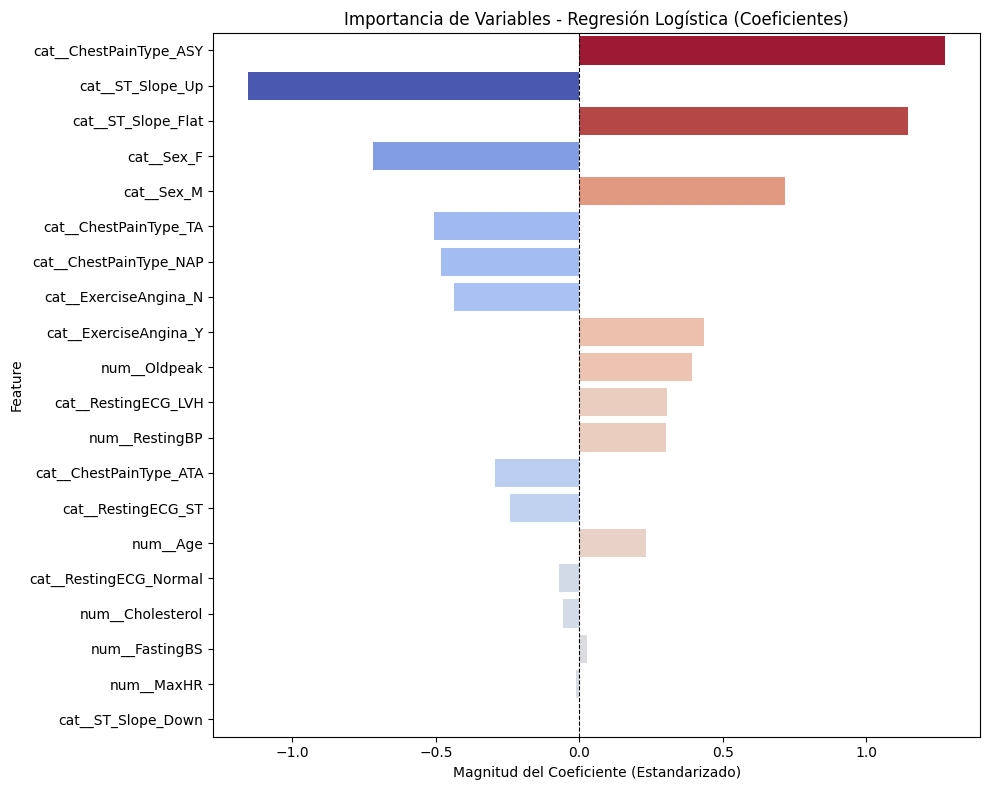

,steps,"[('preprocessor', ...), ('LogisticRegression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [73]:
baseline(df, "HeartDisease")

In [52]:
import plotly
import matplotlib.pyplot as plt

In [55]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, recall_score


In [68]:
import seaborn as sns

In [69]:
def xgb_model(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
    num_cols= X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols= X.select_dtypes(include=['object', 'category']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ])
    pipe=Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', xgb.XGBClassifier(
                            n_estimators=100,
                            max_depth=4,            
                            learning_rate=0.05,    
                            subsample=0.8,          
                            colsample_bytree=0.8,   
                            gamma=1,                
                            eval_metric='auc',  
                            random_state=42))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print("Score in Training Set:", pipe.score(X_train, y_train))
    print("Score in Test Set:", pipe.score(X_test, y_test))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
     # Precision-Recall values
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    avg_prec = average_precision_score(y_test, y_pred)
    rec_at_default = recall_score(y_test, y_pred)

    # --- FEATURE IMPORTANCE (EL NUEVO CÓDIGO) ---
    
    # 1. Recuperar nombres de las columnas transformadas
    # get_feature_names_out() construye los nombres tipo "cat__Sex_M", "num__Age", etc.
    feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
    
    # 2. Recuperar la importancia numérica del modelo
    importances = pipe.named_steps['classifier'].feature_importances_
    
    # 3. Crear DataFrame y ordenar
    fi_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    fi_df = fi_df.sort_values(by='Importance', ascending=False)
    
    # 4. Graficar
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
    plt.title('Feature Importance (XGBoost)', fontsize=15)
    plt.xlabel('Importancia Relativa')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()
    
    return pipe



Score in Training Set: 0.9345637583892618
Score in Test Set: 0.92

Confusion Matrix:
 [[68  3]
 [ 9 70]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92        71
           1       0.96      0.89      0.92        79

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150



C:\Users\APUESTAS\AppData\Local\Temp\ipykernel_33524\42365691.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


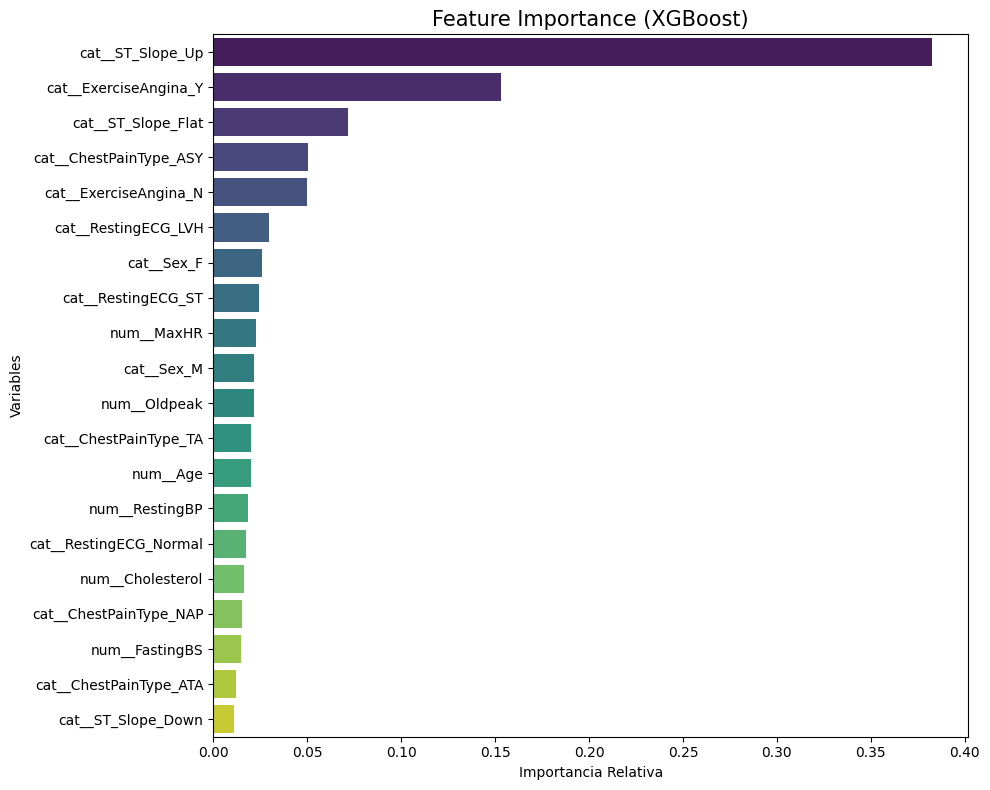

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [71]:
xgb_model(df, "HeartDisease")

In [64]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

def optimize_xgb(df, target_column, seed=42):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Identificar columnas
    num_cols = X.select_dtypes(include=['number']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    def objective(trial):
        # 1. Definir el espacio de búsqueda de hiperparámetros
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            'random_state': seed,
            'eval_metric': 'auc'
        }

        # 2. Crear el preprocesador (igual que en tu función anterior)
        preprocessor = ColumnTransformer([
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ])

        # 3. Crear el Pipeline con los parámetros sugeridos por Optuna
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', xgb.XGBClassifier(**params))
        ])

        # 4. Usar Validación Cruzada para evitar sobreajuste durante la búsqueda
        score = cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()
        return score

    # Crear el estudio y optimizar
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=200) # Prueba 50 combinaciones diferentes

    print("🏆 Mejores parámetros encontrados:", study.best_params)
    print("📈 Mejor Score:", study.best_value)
    
    return study.best_params

In [65]:
optimize_xgb(df, "HeartDisease")

[I 2025-12-17 22:40:04,656] A new study created in memory with name: no-name-484430cd-524e-4503-b5ac-7e129fdb3564
[I 2025-12-17 22:40:05,006] Trial 0 finished with value: 0.8525190156599554 and parameters: {'n_estimators': 84, 'max_depth': 6, 'learning_rate': 0.07959275468486114, 'subsample': 0.8459878917371509, 'colsample_bytree': 0.947064624881099, 'gamma': 0.00033629042807395085}. Best is trial 0 with value: 0.8525190156599554.
[I 2025-12-17 22:40:05,561] Trial 1 finished with value: 0.8659060402684563 and parameters: {'n_estimators': 124, 'max_depth': 9, 'learning_rate': 0.03294072491437649, 'subsample': 0.9493594394764162, 'colsample_bytree': 0.5513076264552512, 'gamma': 2.8044566313466824e-06}. Best is trial 1 with value: 0.8659060402684563.
[I 2025-12-17 22:40:05,950] Trial 2 finished with value: 0.8498523489932885 and parameters: {'n_estimators': 120, 'max_depth': 5, 'learning_rate': 0.0940906791101854, 'subsample': 0.766136250337532, 'colsample_bytree': 0.8473390879609464, 'ga

🏆 Mejores parámetros encontrados: {'n_estimators': 181, 'max_depth': 10, 'learning_rate': 0.02272098629385045, 'subsample': 0.8277989506562178, 'colsample_bytree': 0.552078149192865, 'gamma': 0.0006276852817810874}
📈 Mejor Score: 0.8739328859060403


{'n_estimators': 181,
 'max_depth': 10,
 'learning_rate': 0.02272098629385045,
 'subsample': 0.8277989506562178,
 'colsample_bytree': 0.552078149192865,
 'gamma': 0.0006276852817810874}